In this project, we examine a dataset containing crime statistics in the San Francisco area. The data is analyzed from  analyzed with the goal of creating a model to predict the nature of a crime based only on its time and location. 

More information on the project and its dataset can be found here:
https://www.kaggle.com/c/sf-crime

In [1]:
# First we import the needed packages for python...

%matplotlib inline

import sys, os
import numpy as np
import pandas
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from datetime import datetime
from scipy import stats, integrate
from pandas.tseries.holiday import USFederalHolidayCalendar as holidaysCalendar
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

pandas.options.display.max_columns = 200
pandas.options.display.max_rows = 200

In [2]:
# Define header (from sample submission)- these are the categories of crime we must predict. 
header = ["ID", "ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", "BURGLARY",
          "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", "DRUG/NARCOTIC",
          "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION", "FAMILY OFFENSES",
          "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING", "KIDNAPPING", "LARCENY/THEFT",
          "LIQUOR LAWS", "LOITERING", "MISSING PERSON", "NON-CRIMINAL", "OTHER OFFENSES",
          "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", "RECOVERED VEHICLE", "ROBBERY",
          "RUNAWAY", "SECONDARY CODES", "SEX OFFENSES FORCIBLE", "SEX OFFENSES NON FORCIBLE",
          "STOLEN PROPERTY", "SUICIDE", "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM",
          "VEHICLE THEFT", "WARRANTS", "WEAPON LAWS"]

#### Helper Functions
we define these functions to help parse and add meaning to the data. This is particularly
important because much of the data are strings.

They include-  
--1) Using the time of day to create buckets- ie- 0800= morning  
--2) Whether the location of a crime was on a street corner or in the middle of a block  
--3) Whether the crime (roughly) occured during daytime or nighttime (day defined as after 7am and before 7pm)  
--4) Using the supplied latitude/longitude to determine the crime's zip code  
--5) Whether the crime occured on a holiday  

In [3]:
def SaveResults(result, outputname):
    # Output, format
    ## Add rows for dummy creation for all possible output labels 
    result = np.append(result, list(range(39)))
    ## Convert to pandas data type and create dummies
    result = pandas.DataFrame(result)
    result = pandas.get_dummies(result[0], prefix='', prefix_sep='')
    ## Remove post-prediction added rows
    result = result[:-39]
    ## Save to CSV
    result.to_csv(outputname, compression='gzip', chunksize=1000)

def DetermineTime(hour):
    ## Add early morning, morning, afternoon, early evening, evening, late evening
    ## 0500-0800, 0800-1100, 1100-1600, 1600-2100, 2100-0200, 0200-0500
    if hour <= 2:
        return "evening"
    elif hour <= 5:
        return "lateE"
    elif hour <= 8:
        return "earlyM"
    elif hour <= 11:
        return "morning"
    elif hour <= 16:
        return "afternoon"
    elif hour <= 21:
        return "earlyE"
    else:
        return "evening"

def DetermineLocationType(address):
    ##Add block or corner
    if "block" in address.lower():
        return "block"
    elif "/" in address:
        return "corner"
    return None

def DetermineDayTime(time):
    ##Add Day Time
    time = int(time)
    if time >= 7 and time <= 19:
        return True
    elif time < 7 or time >= 19:
        return False
    return None

def Normalize(X):
    minx = min(X)
    maxx = max(X)
    subx = max(X)-min(X)
    return X.apply(lambda x: (x-minx)/subx)

def DetermineBlockCol(datacol):
    return 10 * round(datacol, 1)
 
def DetermineBlockRow(datarow):
    return 100 * round(datarow, 1)
    
def DetermineBlock(data):
    return int(xrow) + int(yrow)

def DetermineUnemp(data, unemp_dict):
    return unemp_dict[str(data.year)][str(calendar.month_abbr[data.month])]

def GenerateCoordToZipMap(filename, dict, data, read, write):
    # Load coords
    coords = data[['X', 'Y']]
    
    # Create/load dict
    geo_dict = dict
    if read:
        # Load GeoDict from file
        with open(datafile, 'r') as file:
            geo_dict = json.load(file)
    
    # Generate mappings
    for coord in coords.iterrows():
        X = round(coord[1][1], 4)
        Y = round(coord[1][0], 4)
        xy = str(X) + ", " + str(Y)
        # Check if existing
        if xy in geo_dict.keys():
            print ("Found! " + str(geo_dict[xy]) + " X: " + str(X) + "  Y: " + str(Y))
        else:
            success = False
            while not success:
                try:
                    location = geolocator.reverse(xy)
                    zip = location.address.split(',')[-2].strip()
                    geo_dict[xy] = zip
                    print ("Added: " + str(zip) + "  X: " + str(X) + "  Y: " + str(Y))
                    success = True
                except:
                    time.sleep(5)
    if write:
        # Write GeoDict to file
        with open(filename, 'w') as file:
            file.write(json.dumps(geo_dict))
    
    return geo_dict

def CoordsToZip(geo_dict, X, Y):
    X = round(X, 4)
    Y = round(Y, 4)
    xy = str(X) + ", " + str(Y)
    if xy in geo_dict.keys():
        return geo_dict[xy]
    # Not found
    return "00000"

def DetermineHoliday(date, holidays):
    if date in holidays:
        return 1
    return 0


#### Load data
Here we load the data provided by Kaggle. We haven't made any transformations yet. 
The train data has 878,048 crimes, the test data has 884,262 crimes. 
Note that the test data does not include the crime's category (which we are predicting) or its description, 
so we do not want to train the model on these

In [4]:
df_train = pandas.read_csv("train.csv")
df_test = pandas.read_csv("test.csv")

# Drop duplicates
#df_train = df_train.drop_duplicates()
#df_test = df_test.drop_duplicates()

# Shuffle
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

print (df_train.shape)
print (df_test.shape)
print (df_train.head())
print (df_test.head())


(878049, 9)
(884262, 7)
                 Dates        Category  \
0  2008-04-14 17:30:00   LARCENY/THEFT   
1  2008-02-24 12:00:00    NON-CRIMINAL   
2  2010-07-16 20:37:00         ASSAULT   
3  2013-03-08 00:01:00   LARCENY/THEFT   
4  2013-11-15 12:52:00  OTHER OFFENSES   

                                  Descript DayOfWeek PdDistrict  \
0           PETTY THEFT FROM UNLOCKED AUTO    Monday   SOUTHERN   
1                           FOUND PROPERTY    Sunday   NORTHERN   
2  AGGRAVATED ASSAULT WITH A DEADLY WEAPON    Friday    TARAVAL   
3              GRAND THEFT FROM A BUILDING    Friday   SOUTHERN   
4    DRIVERS LICENSE, SUSPENDED OR REVOKED    Friday    CENTRAL   

       Resolution                      Address           X          Y  
0            NONE       800 Block of BRYANT ST -122.403405  37.775421  
1       UNFOUNDED    FILLMORE ST / CHESTNUT ST -122.436275  37.800813  
2  ARREST, BOOKED     500 Block of JOHNMUIR DR -122.492068  37.714362  
3       UNFOUNDED      1100 Bloc

#### Data Additions- Unemployment and weather
Here we wish to pull in weather and unemployment data, which we believe will be important in determining crime. 
We pulled in publicly available data which can be matched to the date of the crime to add the max temp and total
precipitation of the day of the crime and the unemployment rate

Note that the weather is from the SFO Airport station, and unemployment is for the whole state of CA, and is monthly.

In [5]:
# Here we maniuplate a few columns in the train data- the DATE column is formatted to match the weather data,
# and the YR-MTH COLUMN to match to the unemployment data
df_train["DATE"]=df_train.Dates.str.split('\s+').str[0]
df_train['YR-MTH']=df_train['DATE'].map(lambda x: x[:7])

print (df_train.shape)
print (df_train.head())

(878049, 11)
                 Dates        Category  \
0  2008-04-14 17:30:00   LARCENY/THEFT   
1  2008-02-24 12:00:00    NON-CRIMINAL   
2  2010-07-16 20:37:00         ASSAULT   
3  2013-03-08 00:01:00   LARCENY/THEFT   
4  2013-11-15 12:52:00  OTHER OFFENSES   

                                  Descript DayOfWeek PdDistrict  \
0           PETTY THEFT FROM UNLOCKED AUTO    Monday   SOUTHERN   
1                           FOUND PROPERTY    Sunday   NORTHERN   
2  AGGRAVATED ASSAULT WITH A DEADLY WEAPON    Friday    TARAVAL   
3              GRAND THEFT FROM A BUILDING    Friday   SOUTHERN   
4    DRIVERS LICENSE, SUSPENDED OR REVOKED    Friday    CENTRAL   

       Resolution                      Address           X          Y  \
0            NONE       800 Block of BRYANT ST -122.403405  37.775421   
1       UNFOUNDED    FILLMORE ST / CHESTNUT ST -122.436275  37.800813   
2  ARREST, BOOKED     500 Block of JOHNMUIR DR -122.492068  37.714362   
3       UNFOUNDED      1100 Block of FO

In [6]:
# Here we pull in the unemployment data. It was sourced from Quandl.
# We then maniuplate the date column to match with the YR-MNTH column in the train data
unemployment=pandas.read_csv("https://www.quandl.com/api/v3/datasets/FRED/CAUR.csv?api_key=EaN-sDKDUb9c3AXGdQkS")
unemployment['YR-MTH']=unemployment['Date'].map(lambda x: x[:7])

print (unemployment.head())

         Date  Value   YR-MTH
0  2017-10-01    4.9  2017-10
1  2017-09-01    5.1  2017-09
2  2017-08-01    5.1  2017-08
3  2017-07-01    4.8  2017-07
4  2017-06-01    4.7  2017-06


In [7]:
# Here we merge the train data with the unemployment data on the common YR-MTH column. 
# It is a left outer join to not disturb the integrity of the train data otherwise 
df_train=pandas.merge(df_train, unemployment, on ='YR-MTH', how ='left')
df_train=df_train.drop('Date', 1)

print (df_train.shape)
print (df_train.head())


(878049, 12)
                 Dates        Category  \
0  2008-04-14 17:30:00   LARCENY/THEFT   
1  2008-02-24 12:00:00    NON-CRIMINAL   
2  2010-07-16 20:37:00         ASSAULT   
3  2013-03-08 00:01:00   LARCENY/THEFT   
4  2013-11-15 12:52:00  OTHER OFFENSES   

                                  Descript DayOfWeek PdDistrict  \
0           PETTY THEFT FROM UNLOCKED AUTO    Monday   SOUTHERN   
1                           FOUND PROPERTY    Sunday   NORTHERN   
2  AGGRAVATED ASSAULT WITH A DEADLY WEAPON    Friday    TARAVAL   
3              GRAND THEFT FROM A BUILDING    Friday   SOUTHERN   
4    DRIVERS LICENSE, SUSPENDED OR REVOKED    Friday    CENTRAL   

       Resolution                      Address           X          Y  \
0            NONE       800 Block of BRYANT ST -122.403405  37.775421   
1       UNFOUNDED    FILLMORE ST / CHESTNUT ST -122.436275  37.800813   
2  ARREST, BOOKED     500 Block of JOHNMUIR DR -122.492068  37.714362   
3       UNFOUNDED      1100 Block of FO

In [8]:
# Here we load in the weather data from the SFO airport weather station
# We pull the total precipitation for the day, the maximum high temperature, and add a new column, whether precipition > 0
df_weather=pandas.read_csv("climatedata.csv")
df_weather=df_weather[df_weather.STATION=='USW00023234']
df_weather['DID_RAIN']=np.where(df_weather.PRCP >0,1,0)
df_weather=df_weather[['DATE','PRCP','TMAX','DID_RAIN']]

print (df_weather.head())

             DATE  PRCP  TMAX  DID_RAIN
13726  2003-01-01   0.0  53.0         0
13727  2003-01-02   0.0  55.0         0
13728  2003-01-03   0.0  56.0         0
13729  2003-01-04   0.0  59.0         0
13730  2003-01-05   0.0  59.0         0


In [9]:
# Here we merge the train and weather data, using a left outer join on as we did previously to the unemployment data
df_train=pandas.merge(df_train, df_weather, on ='DATE', how ='left')

print (df_train.shape)
print (df_train.head())

(878049, 15)
                 Dates        Category  \
0  2008-04-14 17:30:00   LARCENY/THEFT   
1  2008-02-24 12:00:00    NON-CRIMINAL   
2  2010-07-16 20:37:00         ASSAULT   
3  2013-03-08 00:01:00   LARCENY/THEFT   
4  2013-11-15 12:52:00  OTHER OFFENSES   

                                  Descript DayOfWeek PdDistrict  \
0           PETTY THEFT FROM UNLOCKED AUTO    Monday   SOUTHERN   
1                           FOUND PROPERTY    Sunday   NORTHERN   
2  AGGRAVATED ASSAULT WITH A DEADLY WEAPON    Friday    TARAVAL   
3              GRAND THEFT FROM A BUILDING    Friday   SOUTHERN   
4    DRIVERS LICENSE, SUSPENDED OR REVOKED    Friday    CENTRAL   

       Resolution                      Address           X          Y  \
0            NONE       800 Block of BRYANT ST -122.403405  37.775421   
1       UNFOUNDED    FILLMORE ST / CHESTNUT ST -122.436275  37.800813   
2  ARREST, BOOKED     500 Block of JOHNMUIR DR -122.492068  37.714362   
3       UNFOUNDED      1100 Block of FO

In [10]:
# Here is the same process for the test data, adding both unemployment and weather data:
df_test["DATE"]=df_test.Dates.str.split('\s+').str[0]
df_test['YR-MTH']=df_test['DATE'].map(lambda x: x[:7])

df_test=pandas.merge(df_test, unemployment, on ='YR-MTH', how ='left')
df_test=df_test.drop('Date', 1)

df_test=pandas.merge(df_test, df_weather, on ='DATE', how ='left')

print (df_test.shape)
print (df_test.head())

(884262, 13)
       Id                Dates DayOfWeek PdDistrict  \
0  483409  2008-08-03 01:00:00    Sunday    MISSION   
1  598626  2006-12-07 02:25:00  Thursday    MISSION   
2  262540  2011-10-16 14:50:00    Sunday    TARAVAL   
3  434187  2009-04-10 12:00:00    Friday   SOUTHERN   
4  172029  2013-02-12 19:34:00   Tuesday  INGLESIDE   

                       Address           X          Y        DATE   YR-MTH  \
0      2300 Block of MARKET ST -122.434036  37.763294  2008-08-03  2008-08   
1    400 Block of ELIZABETH ST -122.430866  37.752347  2006-12-07  2006-12   
2        3200 Block of 20TH AV -122.475647  37.728528  2011-10-16  2011-10   
3          600 Block of 8TH ST -122.404685  37.770629  2009-04-10  2009-04   
4  0 Block of SGTJOHNVYOUNG LN -122.444707  37.724931  2013-02-12  2013-02   

   Value  PRCP  TMAX  DID_RAIN  
0    7.8   0.0  64.0         0  
1    4.9   0.0  59.0         0  
2   11.3   0.0  72.0         0  
3   10.9   0.0  59.0         0  
4    9.3   0.0  58.0  

#### Feature Adding:
Here we run the functions defined above to add features to the data based on the original data provided.

We do this for both test and train data.

In [11]:
# Format Dates
## Hour of day
df_train['Hour'] = pandas.to_datetime(df_train['Dates']).dt.hour
df_test['Hour'] = pandas.to_datetime(df_test['Dates']).dt.hour

## Time of day
df_train['Time'] = df_train['Hour'].apply(lambda x: DetermineTime(x))
df_test['Time'] = df_test['Hour'].apply(lambda x: DetermineTime(x))

## Day
df_train['DayTime'] = df_train['Hour'].apply(lambda x: DetermineDayTime(x))
df_test['DayTime'] = df_test['Hour'].apply(lambda x: DetermineDayTime(x))

## Week of year
df_train['Week'] = pandas.to_datetime(df_train['Dates']).dt.week
df_test['Week'] = pandas.to_datetime(df_test['Dates']).dt.week

## Season of year
def DetermineSeason(week):
    if (week >= 47) or (week <=7 ):
        return "Winter"
    if (week >= 8) or (week <=20 ):
        return "Spring"
    if (week >= 21) or (week <=33 ):
        return "Summer"
    if (week >= 34) or (week <=46 ):
        return "Autumn"
    return "Error"

df_train['Season'] = df_train['Week'].apply(lambda x: DetermineSeason(x))
df_test['Season'] = df_test['Week'].apply(lambda x: DetermineSeason(x))

## Reduce to date
df_train['Date'] = pandas.to_datetime(df_train['Dates']).dt.date
df_test['Date'] = pandas.to_datetime(df_test['Dates']).dt.date

# Adjust out of bounds values
median_x = np.median(df_train['X'])
median_y = np.median(df_train['Y'])
def AssignMedianX(x, median_x):
    if x == -120.5:
        return median_x
    else:
        return x
def AssignMedianY(y, median_y):
    if y > 38:
        return median_y
    else:
        return y

df_train['X'] = df_train['X'].apply(lambda x: AssignMedianX(x, median_x))
df_train['Y'] = df_train['Y'].apply(lambda x: AssignMedianY(x, median_y))
df_test['X'] = df_test['X'].apply(lambda x: AssignMedianX(x, median_x))
df_test['Y'] = df_test['Y'].apply(lambda x: AssignMedianY(x, median_y))

## Holidays
cal = holidaysCalendar()
holidays = cal.holidays(start=pandas.to_datetime(df_train['Date']).min(), end=pandas.to_datetime(df_train['Date']).max())

# Not comparing correctly, writing this manually
holiday_list = []
for day in holidays:
    holiday_list.append(str(day).split(' ')[0])
hol_str = str(holiday_list)
df_train['Holiday'] = df_train['Date'].apply(lambda x: DetermineHoliday(str(x), hol_str))
df_test['Holiday'] = df_test['Date'].apply(lambda x: DetermineHoliday(str(x), hol_str))

# Format Address
## Add address type
df_train['LocationType'] = df_train['Address'].apply(lambda x: DetermineLocationType(x))
df_test['LocationType'] = df_test['Address'].apply(lambda x: DetermineLocationType(x))

## Form BlockID
df_train['X'] = Normalize(df_train['X'])
df_train['Y'] = Normalize(df_train['Y'])
blockRow = df_train['X'].apply(lambda x: DetermineBlockRow(x))
blockCol = df_train['Y'].apply(lambda x: DetermineBlockCol(x))
df_train['BlockID'] = blockRow + blockCol

df_test['X'] = Normalize(df_test['X'])
df_test['Y'] = Normalize(df_test['Y'])
blockRow = df_test['X'].apply(lambda x: DetermineBlockRow(x))
blockCol = df_test['Y'].apply(lambda x: DetermineBlockCol(x))
df_test['BlockID'] = blockRow + blockCol

# More dates
df_train['Month'] = df_train['Date'].apply(lambda x: x.month)
df_train['Day'] = df_train['Date'].apply(lambda x: x.day)
df_train['Year'] = df_train['Date'].apply(lambda x: x.year)
df_test['Month'] = df_test['Date'].apply(lambda x: x.month)
df_test['Day'] = df_test['Date'].apply(lambda x: x.day)
df_test['Year'] = df_test['Date'].apply(lambda x: x.year)

#### Exploratory Data Analysis
##### Revelations:
- Add euclidean distance using X,Y
- Add different size 'plots' of land for X,Y (trimming)
- Add temperature, precipitation
- Add block or corner
- Add time of day, day of week, weekend, week of year, season of year, holiday
- Add early morning, morning, afternoon, early evening, evening, late evening
- - 0500-0800, 0800-1100, 1100-1600, 1600-2100, 2100-0200, 0200-0500

##### Columns

In [12]:
print ("Exploring data, columns, and formats")
print ("\nColumns:")
# View all columns
print (df_train.columns)

Exploring data, columns, and formats

Columns:
Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'DATE', 'YR-MTH', 'Value', 'PRCP',
       'TMAX', 'DID_RAIN', 'Hour', 'Time', 'DayTime', 'Week', 'Season', 'Date',
       'Holiday', 'LocationType', 'BlockID', 'Month', 'Day', 'Year'],
      dtype='object')


##### Category


Category:
0    LARCENY/THEFT
1     NON-CRIMINAL
2          ASSAULT
Name: Category, dtype: object
{'LIQUOR LAWS', 'LARCENY/THEFT', 'OTHER OFFENSES', 'PROSTITUTION', 'RUNAWAY', 'ARSON', 'DISORDERLY CONDUCT', 'VANDALISM', 'FRAUD', 'SEX OFFENSES FORCIBLE', 'BURGLARY', 'MISSING PERSON', 'NON-CRIMINAL', 'DRUNKENNESS', 'RECOVERED VEHICLE', 'WARRANTS', 'STOLEN PROPERTY', 'PORNOGRAPHY/OBSCENE MAT', 'SECONDARY CODES', 'FAMILY OFFENSES', 'SUICIDE', 'BAD CHECKS', 'BRIBERY', 'VEHICLE THEFT', 'SEX OFFENSES NON FORCIBLE', 'SUSPICIOUS OCC', 'ROBBERY', 'LOITERING', 'TRESPASS', 'WEAPON LAWS', 'EXTORTION', 'DRUG/NARCOTIC', 'GAMBLING', 'TREA', 'KIDNAPPING', 'FORGERY/COUNTERFEITING', 'EMBEZZLEMENT', 'ASSAULT', 'DRIVING UNDER THE INFLUENCE'}


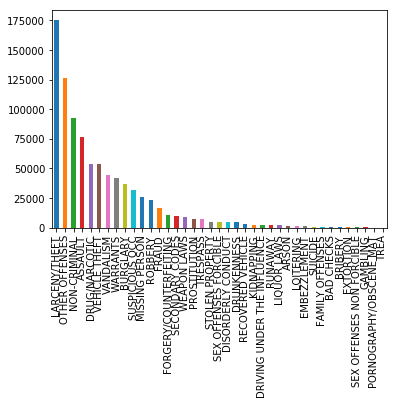

In [13]:
# Explore 'Category'
print ("\nCategory:")
print (df_train['Category'].head(3))
print (set(df_train['Category']))
## OUTCOME VARIABLE
## Possible issue with 'Trea' and 'Trespass'
## Convert 'TREA' to 'TRESPASS'
len(df_train[df_train['Category'] == 'TREA'])

df_train['Category'].value_counts().plot(kind='bar')

In [14]:
# Larceny/theft the largest set of crimes. "Other offenses" and "non-criminal" are next two. This shouldn't affect how the models work, but it is interesting to note
# Otherwise, there aren't any notable issues. "TREA" is probably trespassing. 

##### Descript

In [15]:
# Explore 'Descript'
print ("\nDescript:")
print (df_train['Descript'].head(3))
## NOT IN TEST DATA
## Does not appear to be useful. We do not train the model on this either. We will not consider it further


Descript:
0             PETTY THEFT FROM UNLOCKED AUTO
1                             FOUND PROPERTY
2    AGGRAVATED ASSAULT WITH A DEADLY WEAPON
Name: Descript, dtype: object


##### DayOfWeek


DayOfWeek:
0    Monday
1    Sunday
2    Friday
Name: DayOfWeek, dtype: object
{'Sunday', 'Wednesday', 'Monday', 'Tuesday', 'Friday', 'Thursday', 'Saturday'}
Missing values in DayOfWeek: 0


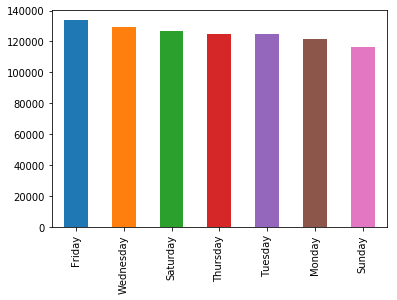

In [16]:
# Explore 'DayOfWeek'
print ("\nDayOfWeek:")
print (df_train['DayOfWeek'].head(3))
print (set(df_train['DayOfWeek']))
total = 0
for x in set(df_train['DayOfWeek']):
    total += len(df_train[df_train['DayOfWeek'] == x])
print ("Missing values in DayOfWeek: " + str(len(df_train) - total))
## Looks good

df_train['DayOfWeek'].value_counts().plot(kind='bar')

In [17]:
#A pretty uniform distribution, but more crimes occur on days where more people go out - like Friday and Saturday. Early in the week has less crime. This is expected

##### PdDistrict


PdDistrict:
0    SOUTHERN
1    NORTHERN
2     TARAVAL
Name: PdDistrict, dtype: object
{'TENDERLOIN', 'SOUTHERN', 'MISSION', 'INGLESIDE', 'BAYVIEW', 'CENTRAL', 'TARAVAL', 'PARK', 'RICHMOND', 'NORTHERN'}
Missing values in PdDistrict: 0


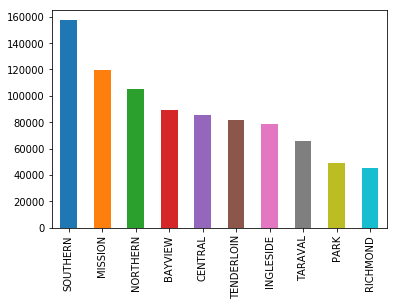

In [18]:
# Explore 'PdDistrict'
print ("\nPdDistrict:")
print (df_train['PdDistrict'].head(3))
print (set(df_train['PdDistrict']))
total = 0
for x in set(df_train['PdDistrict']):
    total += len(df_train[df_train['PdDistrict'] == x])
print ("Missing values in PdDistrict: " + str(len(df_train) - total))
## Looks good

df_train['PdDistrict'].value_counts().plot(kind='bar')

In [19]:
#While we don't know how large the police districts are or where they are located, which will play a big role in what crimes take place where, nothing about the distribution suggests that it wouldn't be useful in the models

##### Resolution

In [20]:
# Explore 'Resolution'
print ("\nResolution:")
print (df_train['Resolution'].head(3))
## NOT IN TEST DATA
## Does not appear to be useful. Since this does not appear in the train data and there is such a long range of strings, we decided not to focus on this and dropped it 


Resolution:
0              NONE
1         UNFOUNDED
2    ARREST, BOOKED
Name: Resolution, dtype: object


##### Address

In [21]:
# Explore 'Address'
print ("\nAddress:")
print (df_train['Address'].head(3))
## Count Blocks, Corners
blocks = corners = neither = 0
for address in df_train['Address']:
    if "block" in address.lower():
        blocks += 1
    elif "/" in address:
        corners += 1
    else:
        neither += 1
print ("Number of blocks: " + str(blocks))
print ("Number of corners: " + str(corners))
print ("Number of neither: " + str(neither))
print ("Number of both: " + str(blocks + corners - (len(df_train) - neither)))


## Most (~2/3) of crimes took place on a block, not on a corner. Interesting to add to model. 


Address:
0       800 Block of BRYANT ST
1    FILLMORE ST / CHESTNUT ST
2     500 Block of JOHNMUIR DR
Name: Address, dtype: object
Number of blocks: 617231
Number of corners: 260818
Number of neither: 0
Number of both: 0


##### 'X' and 'Y'


X and Y:
Empty X coords :2
Empty Y coords :1
Distinct X coords :34242
Distinct Y coords :34242


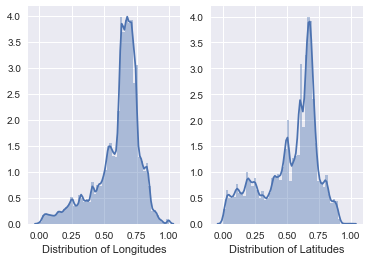

In [22]:
# Explore 'X' and 'Y'
print ("\nX and Y:")
print ("Empty X coords :" + str(len(df_train[df_train['X'] == 0])))
print ("Empty Y coords :" + str(len(df_train[df_train['Y'] == 0])))
print ("Distinct X coords :" + str(len(set(df_train['X']))))
print ("Distinct Y coords :" + str(len(set(df_train['Y']))))

sns.set(color_codes=True)
# Verify integrity of coordinates
#sns.distplot(list(df_train['Y']))


df_train = df_train[df_train['Y'] < 38]
df_train = df_train[df_train['X'] != -120.5]
df_test = df_test[df_test['Y'] < 38]
df_test = df_test[df_test['X'] != -120.5]


plt.subplot(1,2,1)
sns.distplot(list(df_train['X']))
plt.xlabel('Distribution of Longitudes')

plt.subplot(1,2,2)
sns.distplot(list(df_train['Y']))
plt.xlabel('Distribution of Latitudes')





There is a spike in crimes around the centers of the distribution which likely coincides with downtown, where there is more population density, adn we would assume a higher concentration of crimes. 

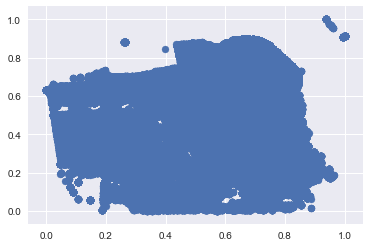

In [23]:
plt.scatter(df_train.X,df_train.Y)

A scatterplot of the crimes latitude and longitude isn't too interesting, because there are so many crimes that the density doesn't show. 
However, it does show the geographic outlines of the city.


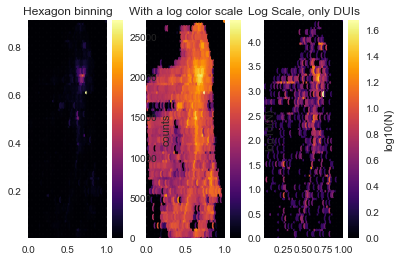

In [24]:
fig, axs = plt.subplots(ncols=3, sharey=True)
ax = axs[0]
hb = ax.hexbin(df_train.X, df_train.Y, gridsize=50, cmap='inferno')
ax.axis([df_train.X.min(), df_train.X.max(), df_train.Y.min(), df_train.Y.max()])
ax.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

ax = axs[1]
hb = ax.hexbin(df_train.X, df_train.Y, gridsize=50, bins='log', cmap='inferno')
ax.axis([df_train.X.min(), df_train.X.max(), df_train.Y.min(), df_train.Y.max()])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

dfXDUI= df_train.X[df_train.Category=='DRIVING UNDER THE INFLUENCE']
dfYDUI=df_train.Y[df_train.Category=='DRIVING UNDER THE INFLUENCE']
ax = axs[2]
hb = ax.hexbin(dfXDUI, dfYDUI, gridsize=50, bins='log', cmap='inferno')
ax.axis([dfXDUI.min(), dfXDUI.max(), dfYDUI.min(), dfYDUI.max()])
ax.set_title("Log Scale, only DUIs")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

plt.show()

To get a better sense of density of crimes, we use a heatmap. 
On the left, the heatmap isn't to helpful because the scale of crimes occuring downtown is so high relative to more outlying areas.
In the center we used a log scale, which much more clearly shows the contours of crime in the city. Interestingly, we can even see areas of high density along highways.
To test this theory, we filtered out DUI crimes only on the right, which we would assume occur in higher prevalence along the city's major roads.
We can clearly see this on the map. This makes it clear that even at a high level, geography is a good indicator of crime. 


#### Unemployment

Mean unemployment rate for crimes= 8.05461494746
Median unemployment rate for crimes= 7.2
Mean unemployment value in CA from 1/03-5-15= 8.08791946309
Median unemployment value in CA from 1/03-5-15= 7.2


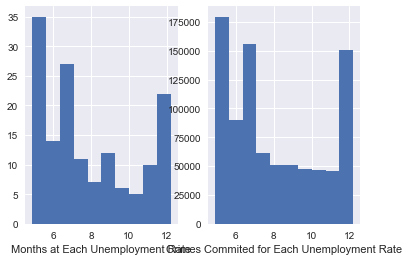

In [25]:
print ("Mean unemployment rate for crimes=", df_train.Value.mean())
print ("Median unemployment rate for crimes=", df_train.Value.median())

print ("Mean unemployment value in CA from 1/03-5-15=", unemployment.Value[29:178].mean())
print ("Median unemployment value in CA from 1/03-5-15=", unemployment.Value[29:178].median())

fig, ax= plt.subplots(nrows=1,ncols=2)

plt.subplot(1,2,1)
plt.hist(df_train.Value[29:178])
plt.xlabel('Months at Each Unemployment Rate')

plt.subplot(1,2,2)
plt.hist(df_train.Value)
plt.xlabel('Crimes Commited for Each Unemployment Rate')

Note that the mean unemployment rate for each crime committed was lower than the overall average unemployment rate over this period. 
This suggests that unemployment may not have a causal link to crime, at least in this setting. Note that there are a lot of other factors, including changes in population, policing strategy, among others that could affect this relationship

#### Weather

mean daily max temp over time period = 66.0524503758
median daily max temp over time period = 65.0
mean daily max temp over each crime committed= 65.9547177759
median daily max temp over each crime committed = 65.0
mean daily precipitation over each crime committed 0.043666162139
median daily precipitation over each crime committed 0.0
mean daily precipitation over time period= 0.0470050547599
median daily precipitation over time period= 0.0
ratio of crimes with precipitation to total crimes 0.16256837602457266
ratio of days with precipitation to total days 0.16470092670598147


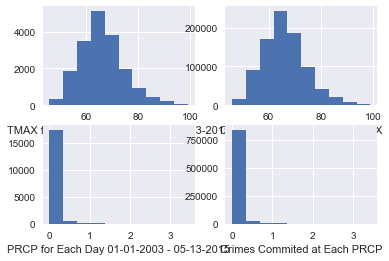

In [26]:
print ("mean daily max temp over time period =", df_train.TMAX.mean())
print ("median daily max temp over time period =", df_train.TMAX.median())

print ("mean daily max temp over each crime committed=",df_weather.TMAX[:18241].mean())
print ("median daily max temp over each crime committed =",df_weather.TMAX[:18241].median())

print ("mean daily precipitation over each crime committed", df_train.PRCP.mean())
print ("median daily precipitation over each crime committed", df_train.PRCP.median())

print ("mean daily precipitation over time period=", df_weather.PRCP[:18241].mean())
print ("median daily precipitation over time period=",df_weather.PRCP[:18241].median())

print ("ratio of crimes with precipitation to total crimes", float(df_train.DID_RAIN.sum())/float(len(df_train.DID_RAIN)))
print ("ratio of days with precipitation to total days", float(df_weather.DID_RAIN[:18241].sum())/float(len(df_weather.DID_RAIN[:18421])))

fig, ax= plt.subplots(nrows=2,ncols=2)

plt.subplot(2,2,1)
plt.hist(df_train.TMAX[:18241])
plt.xlabel('TMAX for Each Day 01-01-2003 - 05-13-2015')

plt.subplot(2,2,2)
plt.hist(df_train.TMAX)
plt.xlabel('Crimes Commited at Each TMAX')

plt.subplot(2,2,3)
plt.hist(df_train.PRCP[:18241])
plt.xlabel('PRCP for Each Day 01-01-2003 - 05-13-2015')

plt.subplot(2,2,4)
plt.hist(df_train.PRCP)
plt.xlabel('Crimes Commited at Each PRCP')

There doesn't seem to be much of a difference between the mean daily max temp and precipitation and the concentration of crimes. 
However, this does not mean that there are not certain crimes that are more or less likely given the weather.
Also, note that SF's weather is pretty steady- most days have no precipitation and mild weather. 

In [27]:
# Now we drop the unnecessary columns that were added during the previous steps
# We also drop the Resolution and Descript columns which are in the train but not test data.
# Descript is what we are predicting 
df_train = df_train.drop(['Dates', 'Address', 'Resolution', 'Descript'],axis=1)
df_test = df_test.drop(['Dates', 'Address', 'Id'],axis=1)

# Name
train_data = df_train
test_data = df_test

#### Encoding
Here we encode the data by adding dummies so that categorical data can be put into the ml models

In [28]:
# Encode time
train_data = train_data.join(pandas.get_dummies(train_data['Time'])).drop('Time', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['Time'])).drop('Time', axis=1)

# Encode LocationType
train_data = train_data.join(pandas.get_dummies(train_data['LocationType'])).drop('LocationType', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['LocationType'])).drop('LocationType', axis=1)

# Encode PdDistrict
train_data = train_data.join(pandas.get_dummies(train_data['PdDistrict'])).drop('PdDistrict', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['PdDistrict'])).drop('PdDistrict', axis=1) 

# Encode DayOfWeek
train_data = train_data.join(pandas.get_dummies(train_data['DayOfWeek'])).drop('DayOfWeek', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['DayOfWeek'])).drop('DayOfWeek', axis=1)

# Encode BlockID
train_data = train_data.join(pandas.get_dummies(train_data['BlockID'])).drop('BlockID', axis=1)
test_data = test_data.join(pandas.get_dummies(test_data['BlockID'])).drop('BlockID', axis=1)
train_data = train_data.drop('X', axis=1)
train_data = train_data.drop('Y', axis=1)
test_data = test_data.drop('X', axis=1)
test_data = test_data.drop('Y', axis=1)

In [29]:
# Label Encoding
le = preprocessing.LabelEncoder()
for column in train_data.columns:
    if train_data[column].dtype == type(object):
        train_data[column] = le.fit_transform(train_data[column])
for column in test_data.columns:
    if test_data[column].dtype == type(object):
        test_data[column] = le.fit_transform(test_data[column])

In [30]:
# Split into data/labels, train/dev
train_labels = train_data['Category'][:-50000]
dev_labels = train_data['Category'][-50000:]

train_data = train_data[train_data.columns.difference(['Category'])][:-50000]
dev_data = train_data[train_data.columns.difference(['Category'])][-50000:]

# Labels list
labels = list(set(train_labels))
train_labels = train_labels.apply(lambda x: labels.index(x))
dev_labels = dev_labels.apply(lambda x: labels.index(x))

# Add missing column to test data
test_data['89.0'] = 0

### K-Nearest Neighbor
Accuracy: 0.16172

In [ ]:
# Train
neigh = KNeighborsClassifier(n_neighbors=50)
# Fit
neigh.fit(train_data, train_labels) 
# Score
print (neigh.score(dev_data, dev_labels))

In [ ]:
# Predict
result_neigh = neigh.predict(test_data)

In [ ]:
# Save
SaveResults(result_neigh, "output_neigh.csv.gzip")

##### Parameter Optimizations

In [ ]:
#parameters = {'n_neighbors': range(1,2500, 250)}
#neigh = GridSearchCV(KNeighborsClassifier(), parameters)
#neigh.fit(train_data, train_labels)
#print (sorted(neigh.cv_results_.keys()))

### AdaBoost
Accuracy: 0.10008

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Train
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=50),n_estimators=100,learning_rate=1)
# Fit
adab.fit(train_data, train_labels)
# Score
print (adab.score(dev_data, dev_labels))

In [ ]:
# Predict
result_adab = adab.predict(test_data)

In [ ]:
# Save
SaveResults(result_adab, "output_adab.csv.gzip")

#### Parameter Optimizations

In [ ]:
#parameters = {'n_estimators': range(1,150, 15), 'learning_rate': range(1,3,0.5)}
#adab_gsv = GridSearchCV(AdaBoostClassifier(), parameters)
#adab_gsv.fit(train_data, train_labels)
#print (sorted(adab_gsv.cv_results_.keys()))

### Random Forests
Accuracy: 0.13748

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train
rfc = RandomForestClassifier(n_estimators=120, max_depth=75, min_samples_split=20, random_state=0)
# Fit
rfc.fit(train_data, train_labels)
# Score
print (rfc.score(dev_data, dev_labels))

In [ ]:
# Predict
result_rfc = rfc.predict(test_data)

In [ ]:
# Save
SaveResults(result_rfc, "output_rfc.csv.gzip")

#### Parameter Optimizations

In [ ]:
#parameters = {'n_estimators': range(1,150, 15), 'min_samples_split': range(1,25, 5), 'max_depth': range(25,100,25)}
#rfc = GridSearchCV(RandomForestClassifier(), parameters)
#rfc.fit(train_data, train_labels)
#print (sorted(rfc.cv_results_.keys()))

### Voting Classifier
Accuracy: 0.13654

In [ ]:
from sklearn.ensemble import VotingClassifier
# Initial ensemble
voting_clf = VotingClassifier(estimators=[
         ('knn', neigh), ('adab', adab), ('rfc', rfc)], voting='hard', weights=[1,1,.75])
# Fit
voting_clf = voting_clf.fit(train_data, train_labels)
# Score
print (voting_clf.score(dev_data, dev_labels))

In [ ]:
# Predict
result_voting_clf = voting_clf.predict(test_data)

In [ ]:
# Save
SaveResults(result_voting_clf, "output_voting_clf.csv.gzip")

### Neural-Network
##### Final Parameters:

In [31]:
numFeatures = len(train_data.columns)
numClasses = len(labels)
numSamples = len(train_data)
numTestExamples = len(dev_data)

print (numFeatures)
print (numClasses)
print (numSamples)
print (numTestExamples)

132
39
828049
50000


#### Sequential

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, ActivityRegularization
from keras.layers import Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers, regularizers

# Define
sequential_model = Sequential()
sequential_model.add(Dense(units=numFeatures * 4, activation='hard_sigmoid', input_shape=(numFeatures,)))
sequential_model.add(Dropout(0.2, noise_shape=None, seed=None))
sequential_model.add(Dense(units=numFeatures * 2, kernel_regularizer=regularizers.l2(0.01)))
sequential_model.add(Dense(units=numFeatures, activity_regularizer=regularizers.l1(0.01)))
sequential_model.add(Dense(units=numFeatures, activation='softmax'))
sequential_model.add(Dense(units=numClasses))

# Compile
sequential_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])
# Fit
sequential_model.fit(train_data.values, train_labels.values, epochs=20, batch_size=100)

Using TensorFlow backend.


Epoch 1/20
828049/828049 [==============================] - 123s 148us/step - loss: 6.0973 - acc: 0.0503
Epoch 2/20
828049/828049 [==============================] - 122s 147us/step - loss: 5.4678 - acc: 0.0612
Epoch 3/20
828049/828049 [==============================] - 122s 147us/step - loss: 5.0342 - acc: 0.0612
Epoch 4/20
106200/828049 [==>...........................] - ETA: 1:53 - loss: 4.9693 - acc: 0.0602

In [ ]:
# Score
print (sequential_model.evaluate(dev_data.values, dev_labels.values, batch_size=100))

In [ ]:
# Predict
result_keras = sequential_model.predict(test_data.values, batch_size=100)

In [ ]:
# Save
SaveResults(result_keras, "output_keras.csv.gzip")

In [ ]:
""" Previous ANN Model
# (1) Parameters
tf.reset_default_graph()

# Constants
testX = tf.constant(dev_data.values, dtype=tf.float32)
hiddenlayer1_size = 2
hiddenlayer2_size = 1
miniBatchSize = 1

# placeholders
x_ = tf.placeholder(tf.float32, shape=[None, numFeatures], name='x')
y_ = tf.placeholder(tf.int32, shape=[None], name='y')

# and Variables
w1 = tf.get_variable('w1', shape=[numFeatures, hiddenlayer1_size])
b1 = tf.get_variable('b1', shape=[hiddenlayer1_size])
w2 = tf.get_variable('w2', shape=[hiddenlayer1_size, numClasses])
b2 = tf.get_variable('b2', shape=[numClasses])


# (2) Model
def model(input_layer):
    hidden_layer1 = tf.nn.sigmoid(tf.matmul(input_layer, w1) + b1)
    output_layer = tf.nn.softmax(tf.matmul(hidden_layer1, w2) + b2)
    return output_layer

# (2) Model
def model_r(input_layer):
    hidden_layer1 = tf.nn.relu(tf.matmul(input_layer, w1) + b1)
    output_layer = tf.nn.softmax(tf.matmul(hidden_layer1, w2) + b2)
    return output_layer
    

# (3) Cost
def cost(data, labels):
    cc = tf.sqrt(tf.square(labels - model(data)))
    return  cc

# (4) Ojbective (and solver)
y_one_hot = tf.one_hot(y_, numClasses)
cc = cost(x_, y_one_hot)
gd = tf.train.GradientDescentOptimizer(0.1)
step = gd.minimize(cc)
test_preds = model(testX)
test_preds_r = model_r(testX)
output = ""
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_vec = []
    cost_vec_r = []
    for i in range(15):
        print (i)
        for start, end in zip(range(0, numSamples, miniBatchSize), range(miniBatchSize, numSamples, miniBatchSize)):
            batch = train_data.values[start:end], train_labels[start:end]
            _, cost, test__preds_r = sess.run([step, cc, test_preds_r], feed_dict={x_: batch[0], y_: batch[1]})
"""